In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt

In [2]:
# Disable scikit-learn warnings
import warnings
from sklearn.exceptions import ConvergenceWarning

## **Setup**

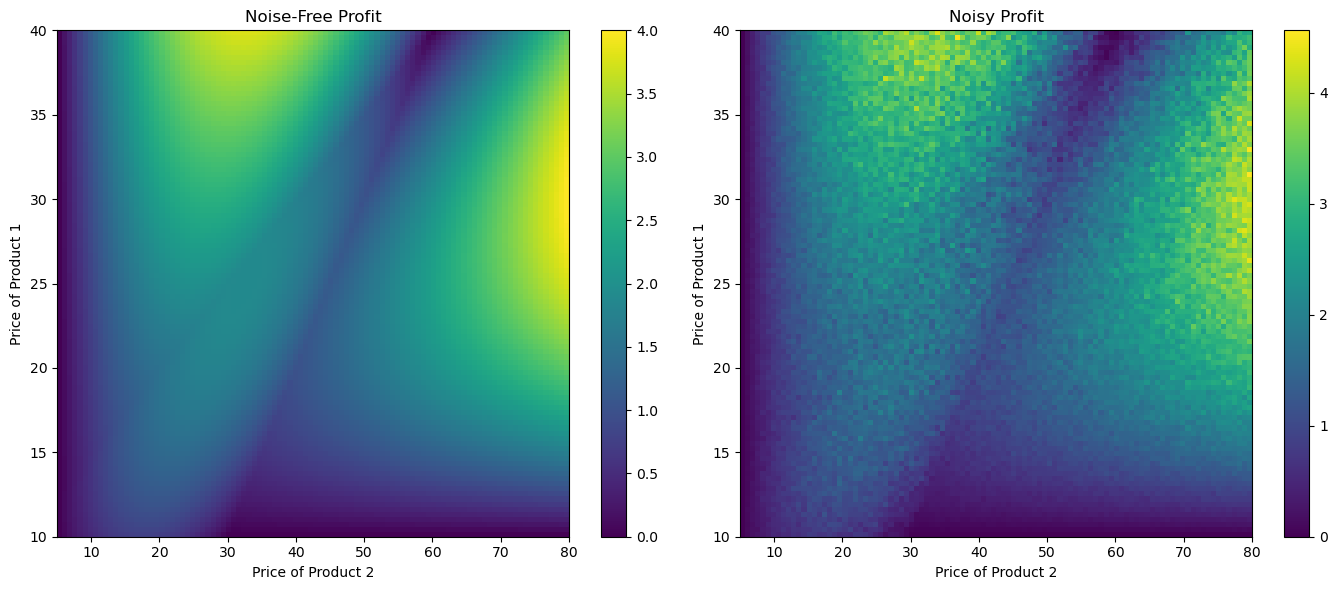

In [3]:
# Fix random seed for reproducibility
SEED = 1234
np.random.seed(SEED)

# Parameters
a1 = 100            # Base demand for product i1
b1 = 10             # Price sensitivity for product i1
c1 = 5              # Cross elasticity of demand for product i1
a2 = 100            # Base demand for product i2
b2 = 5              # Price sensitivity for product i2
c2 = 5              # Cross elasticity of demand for product i2
cost1 = 10          # Cost of product i1
cost2 = 5           # Cost of product i2
max_price = 60      # Maximum price for each product
n_customers = 1000  # Total number of potential customers

# Interaction parameters
T = 1000            # Number of interaction rounds
discretization = 30 # Discretization of the price space for the GP

# Normalized demand functions
def demand_i1(p1, p2):
    return max(0, (a1 - b1 * p1 + c1 * p2) / n_customers)

def demand_i2(p1, p2):
    return max(0, (a2 - b2 * p2 + c2 * p1) / n_customers)

# Noise-free profit function
def profit(p1, p2):
    d1 = demand_i1(p1, p2)
    d2 = demand_i2(p1, p2)
    profit1 = d1 * (p1 - cost1)
    profit2 = d2 * (p2 - cost2)
    return profit1 + profit2

# Noisy demand functions with proper handling for small number of customers
def noisy_demand_i1(p1, p2):
    mean_demand = demand_i1(p1, p2)
    if mean_demand > 1.0:
        mean_demand = 1.0
    elif mean_demand < 0.0:
        mean_demand = 0.0
    return np.random.binomial(n_customers, mean_demand)

def noisy_demand_i2(p1, p2):
    mean_demand = demand_i2(p1, p2)
    if mean_demand > 1.0:
        mean_demand = 1.0
    elif mean_demand < 0.0:
        mean_demand = 0.0
    return np.random.binomial(n_customers, mean_demand)

# Noisy profit function
def noisy_profit(p1, p2):
    d1 = noisy_demand_i1(p1, p2) / n_customers
    d2 = noisy_demand_i2(p1, p2) / n_customers
    profit1 = d1 * (p1 - cost1)
    profit2 = d2 * (p2 - cost2)
    return profit1 + profit2

# Function to compute viable price ranges
def compute_viable_price_ranges():
    # Compute viable price range for p1
    p1_min = max(0, cost1)                          # Ensure p1 is not below cost1
    p1_max = max((a1 + c1 * max_price) / b1, cost1) # Price can be at most max_price
    p1_values = np.linspace(p1_min, p1_max, 100)
    
    # Compute viable price range for p2
    p2_min = max(0, cost2)                          # Ensure p2 is not below cost2
    p2_max = max((a2 + c2 * max_price) / b2, cost2) # Price can be at most max_price
    p2_values = np.linspace(p2_min, p2_max, 100)
    
    return p1_values, p2_values

# Function to plot noise-free and noisy profit curves
def plot_profit_curves():
    # Get viable price ranges
    p1_values, p2_values = compute_viable_price_ranges()
    
    # Initialize arrays to store profit and noisy profit values
    profit_values = np.zeros((len(p1_values), len(p2_values)))
    noisy_profit_values = np.zeros((len(p1_values), len(p2_values)))
    
    # Calculate profit and noisy profit for each pair of prices
    for i, p1 in enumerate(p1_values):
        for j, p2 in enumerate(p2_values):
            profit_values[i, j] = profit(p1, p2)
            noisy_profit_values[i, j] = noisy_profit(p1, p2)
    
    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot noise-free profit curve
    im1 = ax1.imshow(profit_values, extent=(p2_values[0], p2_values[-1], p1_values[0], p1_values[-1]),
                     origin='lower', cmap='viridis', aspect='auto', interpolation='nearest')
    ax1.set_title('Noise-Free Profit')
    ax1.set_xlabel('Price of Product 2')
    ax1.set_ylabel('Price of Product 1')
    fig.colorbar(im1, ax=ax1)
    
    # Plot noisy profit curve
    im2 = ax2.imshow(noisy_profit_values, extent=(p2_values[0], p2_values[-1], p1_values[0], p1_values[-1]),
                     origin='lower', cmap='viridis', aspect='auto', interpolation='nearest')
    ax2.set_title('Noisy Profit')
    ax2.set_xlabel('Price of Product 2')
    ax2.set_ylabel('Price of Product 1')
    fig.colorbar(im2, ax=ax2)
    
    plt.tight_layout()
    plt.show()

# Plot profit and noisy profit curves
plot_profit_curves()

In [4]:
# Print viable price ranges
p1_values, p2_values = compute_viable_price_ranges()
price_range_p1 = (p1_values[0], p1_values[-1])
price_range_p2 = (p2_values[0], p2_values[-1])

print('Viable price range for p1:', price_range_p1)
print('Viable price range for p2:', price_range_p2)

Viable price range for p1: (10.0, 40.0)
Viable price range for p2: (5.0, 80.0)


## **Environment**

In [5]:
class PricingEnvironment:
    def __init__(self, noisy_profit):
        self.noisy_profit = noisy_profit
    
    def round(self, prices_t):
        p1, p2 = prices_t
        return self.noisy_profit(p1, p2)

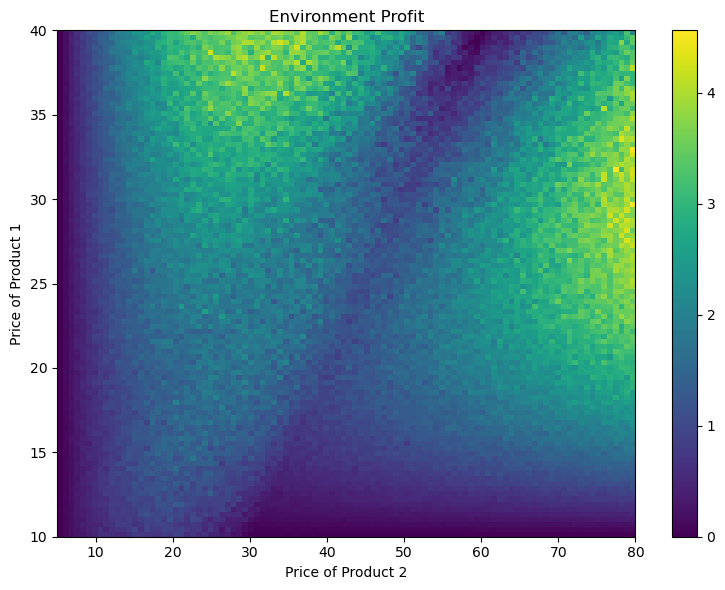

In [6]:
env = PricingEnvironment(noisy_profit)

env_profits = []

for p1 in p1_values:
    for p2 in p2_values:
        env.round((p1, p2))
        env_profits.append(env.round((p1, p2)))

# Contour plot of the environment's profit function
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(np.array(env_profits).reshape(len(p1_values), len(p2_values)),
               extent=(price_range_p2[0], price_range_p2[1], price_range_p1[0], price_range_p1[1]),
               origin='lower', cmap='viridis', aspect='auto', interpolation='nearest')
ax.set_title('Environment Profit')
ax.set_xlabel('Price of Product 2')
ax.set_ylabel('Price of Product 1')
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

## **Clairvoyant**

In [7]:
# Compute prices that maximize profit
max_profit = -np.inf
optimal_prices = (0, 0)

for i, p1 in enumerate(p1_values):
    for j, p2 in enumerate(p2_values):
        p = profit(p1, p2)
        if p > max_profit:
            max_profit = p
            optimal_prices = (p1, p2)
            optimal_prices_idx = (i, j)

print('Optimal prices index:', optimal_prices_idx)
print('Optimal prices:', optimal_prices)

Optimal prices index: (66, 99)
Optimal prices: (30.0, 80.0)


In [8]:
# Clairvoyant rewards
expected_clairvoyant_rewards = np.repeat(max_profit, T)
expected_clairvoyant_rewards.shape

(1000,)

## **2D GP-UCB**

In [9]:
class GPUCBAgent:
    def __init__(self, T, price_ranges, discretization=100, rbf_length_scale=1.0):
        self.T = T
        self.price_ranges = price_ranges    # Tuple of (p1_values, p2_values)
        self.discretization = discretization
        self.scaler = StandardScaler()
        self.arms, self.denormalized_arms = self.generate_2d_arms()
        kernel = C() * RBF(length_scale=rbf_length_scale)
        self.gp = GaussianProcessRegressor(kernel=kernel)
        self.action_t = None
        self.action_history = []
        self.reward_history = []
        self.mu_t = np.zeros(len(self.arms))
        self.sigma_t = np.zeros(len(self.arms))
        self.gamma = lambda t: np.log(t + 1) ** 2
        self.beta = lambda t: 1 + 0.5 * np.sqrt(2 * (self.gamma(t) + 1 + np.log(T)))
        self.n_pulls = np.zeros(len(self.arms))
        self.t = 0

    def generate_2d_arms(self):
        p1_values = np.linspace(self.price_ranges[0][0], self.price_ranges[0][1], self.discretization)
        p2_values = np.linspace(self.price_ranges[1][0], self.price_ranges[1][1], self.discretization)
        arms = np.array(np.meshgrid(p1_values, p2_values)).T.reshape(-1, 2)
        denormalized_arms = arms.copy()
        normalized_arms = self.scaler.fit_transform(arms)
        return normalized_arms, denormalized_arms

    def pull_arm(self):
        warnings.simplefilter('ignore', category=ConvergenceWarning)
        self.mu_t, self.sigma_t = self.gp.predict(self.arms, return_std=True)
        ucbs = self.mu_t + self.beta(self.t) * self.sigma_t
        self.action_t = np.argmax(ucbs)
        return self.denormalized_arms[self.action_t]

    def update(self, reward_t):
        chosen_arm = self.arms[self.action_t]
        self.n_pulls[self.action_t] += 1
        self.action_history.append(chosen_arm)
        self.reward_history.append(reward_t)
        self.gp.fit(self.action_history, self.reward_history)
        self.t += 1

In [10]:
# Initialization
env = PricingEnvironment(noisy_profit)
agent = GPUCBAgent(T, price_ranges=(price_range_p1, price_range_p2), discretization=discretization)

# Interaction loop
agent_rewards = np.array([])

for t in range(T):
    prices_t = agent.pull_arm()
    reward_t = env.round(prices_t)
    agent.update(reward_t)

    agent_rewards = np.append(agent_rewards, reward_t)

cumulative_regret = np.cumsum(expected_clairvoyant_rewards - agent_rewards)

## **Results**

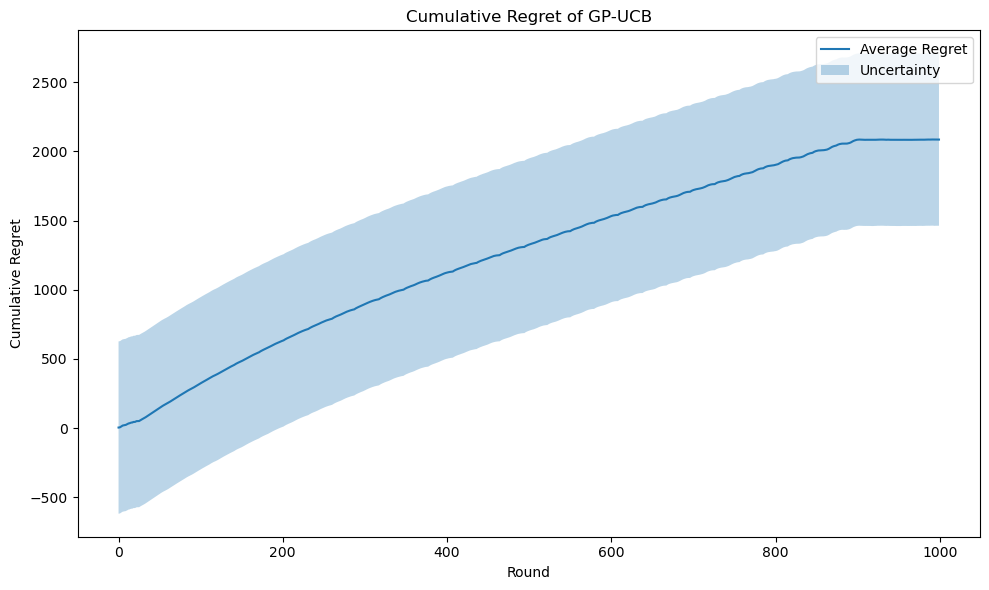

In [11]:
# Plotting
cumulative_regret_mean = np.mean(cumulative_regret)
cumulative_regret_std = np.std(cumulative_regret)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_regret, label='Average Regret')
plt.fill_between(np.arange(T), cumulative_regret - cumulative_regret_std, cumulative_regret + cumulative_regret_std, alpha=0.3, label='Uncertainty')
plt.xlabel('Round')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret of GP-UCB')
plt.legend()
plt.tight_layout()
plt.show()

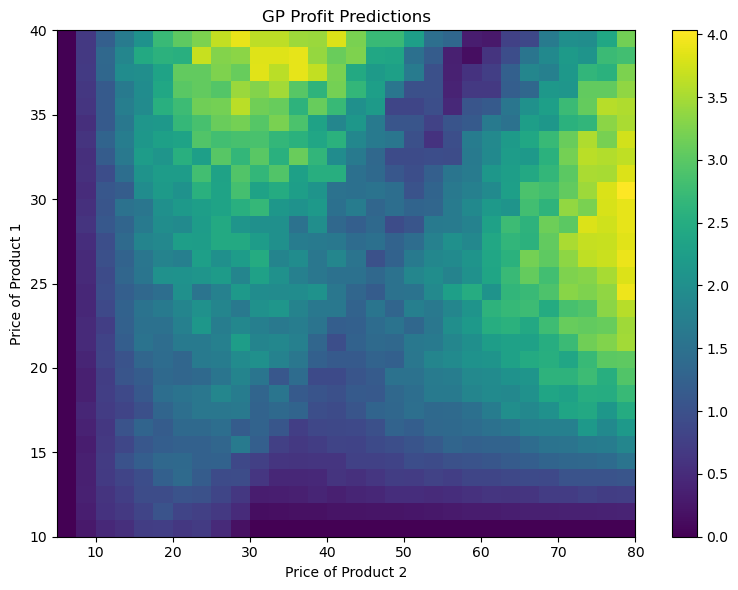

In [12]:
# Contour plot of GP profit predictions
mu_t = agent.mu_t.reshape(discretization, discretization)
sigma_t = agent.sigma_t.reshape(discretization, discretization)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(mu_t, extent=(price_range_p2[0], price_range_p2[1], price_range_p1[0], price_range_p1[1]),
               origin='lower', cmap='viridis', aspect='auto', interpolation='nearest')
ax.set_title('GP Profit Predictions')
ax.set_xlabel('Price of Product 2')
ax.set_ylabel('Price of Product 1')
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()